In [1]:
# Explore the data and then build a wrangle function 

In [2]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Import dataset and concatenate 

In [4]:
# Old wrangle function
def wrangle(filepath):
    df = pd.read_excel(filepath)

    # Subset data: houses 
    mask_house = df["property_type"] == "house"

    df = df[mask_house]

    # Remove outliers in "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon"
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand = True).astype(float)
    df.drop(columns = "lat-lon", inplace = True) # Drop the old column 

    # Extract neighborhood
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns = "place_with_parent_names", inplace = True)

    # # Drop n/a 
    # df.dropna(subset = ["price_aprox_usd", "neighborhood"], inplace = True)

    return df 

In [5]:
files = glob("data/real-estate-*.xlsx")
files

['data/real-estate-1.xlsx',
 'data/real-estate-5.xlsx',
 'data/real-estate-4.xlsx',
 'data/real-estate-3.xlsx',
 'data/real-estate-2.xlsx']

In [6]:
frames = [wrangle(file) for file in files]

In [7]:
# Concatenate frames 
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10480 entries, 0 to 10479
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   10480 non-null  object 
 1   property_type               10480 non-null  object 
 2   price                       9419 non-null   float64
 3   currency                    9419 non-null   object 
 4   price_aprox_local_currency  9419 non-null   float64
 5   price_aprox_usd             9419 non-null   float64
 6   surface_total_in_m2         9399 non-null   float64
 7   surface_covered_in_m2       10480 non-null  float64
 8   price_usd_per_m2            7794 non-null   float64
 9   price_per_m2                9419 non-null   float64
 10  floor                       26 non-null     float64
 11  rooms                       4935 non-null   float64
 12  expenses                    344 non-null    float64
 13  lat                         745

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,lat,lon,neighborhood
0,sell,house,250000.0,USD,3790600.0,250000.0,117.0,120.0,2136.752137,2083.333333,NaN,4.0,NaN,NaN,NaN,La Matanza
1,sell,house,410000.0,USD,6216584.0,410000.0,410.0,220.0,1000.000000,1863.636364,NaN,NaN,NaN,-34.649700,-58.658073,Morón
2,sell,house,180000.0,USD,2729232.0,180000.0,200.0,135.0,900.000000,1333.333333,NaN,5.0,NaN,-34.595709,-58.566950,Tres de Febrero
3,sell,house,130000.0,USD,1971112.0,130000.0,300.0,140.0,433.333333,928.571429,NaN,NaN,NaN,-34.655209,-58.697320,Ituzaingó
4,sell,house,230000.0,USD,3487352.0,230000.0,290.0,230.0,793.103448,1000.000000,NaN,5.0,NaN,-34.652173,-58.577867,La Matanza


## Explore

In [8]:
# 1. Check to drop columns that have more than 50% null(missing) values
df.isnull().sum() / len(df)

operation                     0.000000
property_type                 0.000000
price                         0.101240
currency                      0.101240
price_aprox_local_currency    0.101240
price_aprox_usd               0.101240
surface_total_in_m2           0.103149
surface_covered_in_m2         0.000000
price_usd_per_m2              0.256298
price_per_m2                  0.101240
floor                         0.997519
rooms                         0.529103
expenses                      0.967176
lat                           0.289027
lon                           0.289027
neighborhood                  0.000000
dtype: float64

In [9]:
# Thus, drop "floor" and "expenses" 
df = df.drop(columns=["floor", "expenses"])

In [10]:
# 2. Check columns that give no useful information (low, high cardinality) -> `object` columns either only have one value, or too many different values  
df.select_dtypes("object").head()
df.select_dtypes("object").nunique()

operation         1
property_type     1
currency          2
neighborhood     81
dtype: int64

In [11]:
# Thus, drop "operation", "property_type" and "currency" due to low cardinality 
df = df.drop(columns=["operation", "property_type", "currency"])

In [12]:
# 3. Check to drop leaky columns -> columns that give info about the target to the model that wouldn't be accessible in real life 
sorted(df.columns) # See all the columns

['lat',
 'lon',
 'neighborhood',
 'price',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'price_per_m2',
 'price_usd_per_m2',
 'rooms',
 'surface_covered_in_m2',
 'surface_total_in_m2']

In [13]:
# Thus, given our target "price_aprox_usd", we should drop columns: 
# "price", "price_aprox_local_currency", "price_per_m2", "price_usd_per_m2"
df = df.drop(columns=["price", "price_aprox_local_currency", "price_per_m2", "price_usd_per_m2"])

In [14]:
# 4. Check multicollinearity
# Only select numerical features -> "number", and also ignore the target "price_aprox_usd"
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
corr

,surface_total_in_m2,surface_covered_in_m2,rooms,lat,lon
surface_total_in_m2,1.000000,0.096032,0.000949,-0.000897,-0.001208
surface_covered_in_m2,0.096032,1.000000,0.478007,0.022024,-0.009834
rooms,0.000949,0.478007,1.000000,0.000556,0.009450
lat,-0.000897,0.022024,0.000556,1.000000,-0.549532
lon,-0.001208,-0.009834,0.009450,-0.549532,1.000000


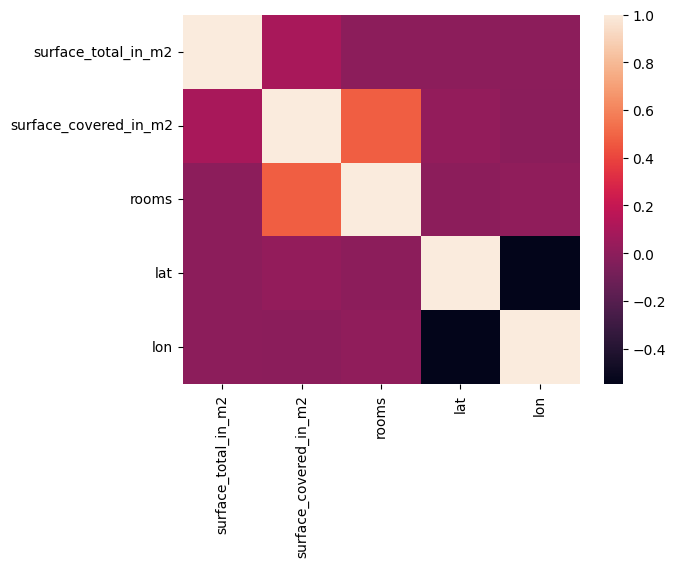

In [15]:
# Check multicollinearity using a heatmap 
sns.heatmap(corr);

plt.savefig("images/fig5.1_heatmap.png")
plt.show()

In [16]:
# Check which one has more value to keep
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10480 entries, 0 to 10479
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        9419 non-null   float64
 1   surface_total_in_m2    9399 non-null   float64
 2   surface_covered_in_m2  10480 non-null  float64
 3   rooms                  4935 non-null   float64
 4   lat                    7451 non-null   float64
 5   lon                    7451 non-null   float64
 6   neighborhood           10480 non-null  object 
dtypes: float64(6), object(1)
memory usage: 573.3+ KB


In [17]:
# Thus, drop "surface_total_in_m2" and "rooms" due to lower non-null values than "surface_covered_in_m2"
df = df.drop(columns = ["surface_total_in_m2", "rooms"])

In [18]:
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,250000.0,120.0,NaN,NaN,La Matanza
1,410000.0,220.0,-34.649700,-58.658073,Morón
2,180000.0,135.0,-34.595709,-58.566950,Tres de Febrero
3,130000.0,140.0,-34.655209,-58.697320,Ituzaingó
4,230000.0,230.0,-34.652173,-58.577867,La Matanza
